In [806]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import datetime
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# Formulas

In [477]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [292]:
# Step 1 : target creation + train_test_split
# Creating target variables to automate creation of quarterly, yearly and 2-yearly targets, because well, DON'T REPEAT YOURSELF!
def create_target_variable(df, frequency:int, threshold):
    if frequency == 1:
        col = 'mc_qtr_growth_pct'
    if frequency == 4:
        col = 'mc_yr_growth_pct'
    if frequency == 8:
        col = 'mc_2yr_growth_pct'
   #else:
   #    raise ValueError("Invalid frequency. Use 1 (quarterly), 4 (yearly), or 8 (2-year).")
    df[col] = df[col].shift(-frequency)
    df.dropna(subset=col, inplace=True)
    target_func = lambda x: 1 if ((x[col] > threshold) & (x.small_cap == 1)) else 0
    df['target'] = df.apply(target_func, axis=1)
    return df

# Creating a custom function for the group split
def group_train_test_split(data, test_size=0.2, random_state=None):
    # We split by groups (company ticker) while keeping the data structure intact.
    unique_groups = data['Ticker'].unique()
    train_groups, test_groups = train_test_split(unique_groups, test_size=test_size, random_state=random_state)
    X_train = data[data['Ticker'].isin(train_groups)].drop(['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct'], axis = 1)
    X_test = data[data['Ticker'].isin(test_groups)].drop(['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct'], axis = 1)
    y_train = data[data['Ticker'].isin(train_groups)]['target']
    y_test = data[data['Ticker'].isin(test_groups)]['target']
    return X_train, X_test, y_train, y_test

In [293]:
# Step 2: Identify numerical and categorical features
def identify_feature_types(df):
    """Identifies the numerical and categorical columns in the DataFrame."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Exclude 'Ticker' from categorical features as it's not needed for transformation
    if 'target' in numerical_features:
        numerical_features.remove('target')
    if 'cik' in numerical_features:
        numerical_features.remove('cik')
    if 'TICKER' in categorical_features:
        categorical_features.remove('TICKER')
    if 'quarter' in categorical_features:
        categorical_features.remove('quarter')

    return numerical_features, categorical_features

In [294]:
# Step 3: Create preprocessing pipeline for numerical and categorical features
def create_preprocessing_pipeline(numerical_features, categorical_features):
    """Creates the preprocessing pipeline for numerical and categorical features."""
    # Preprocessing for numerical data: RobustScaler to make our numbers más robusto.
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaNs
        ('scaler', RobustScaler())  # Scale the data
    ])

    # Preprocessing for categorical data: OneHotEncoder to give each category its own columm...
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categories
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categories
    ])

    # Combine the transformers into one big ColumnTransformer.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

In [295]:
# Step 4: Function to preprocess data in training mode (fitting the pipeline)
def preprocess_training_data(X_train, preprocessor=None):
    """Fits and transforms the training data using the provided pipeline."""
    if preprocessor is None:
        # Identify feature types
        numerical_features, categorical_features = identify_feature_types(X_train)
        preprocessor = create_preprocessing_pipeline(numerical_features, categorical_features)

    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    return X_train_processed, preprocessor

In [296]:
# Step 5: Function to preprocess new/unseen/test data in production mode (only transforming)
def preprocess_new_data(X_new, preprocessor):
    """Transforms new/unseen/test data using a pre-fitted pipeline."""
    if preprocessor is None:
        raise ValueError("The preprocessor must be fitted on training data first before transforming new data.")

    # Transform the new data (no fitting here)
    X_new_processed = preprocessor.transform(X_new)
    return X_new_processed

In [297]:
# Step 6: Function to predict based on different target inputs defined at the create_target_variable stage: quarterly (frequency=1), yearly (frequency=4), and 2-year (frequency=8) predictions
def train_logistic_regression(X_train, y_train, X_test, y_test):
    """ Trains and evaluates a logistic regression model, and returns multiple evaluation metrics
    (accuracy, precision, recall, F1-score) using cross-validation and test data.
    """
    # Train logistic regression model with a progress bar
    logistic_model = LogisticRegression(solver='saga', max_iter=5000)

    # Display progress during model fitting
    with tqdm(total=100, desc="Training Logistic Regression", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        logistic_model.fit(X_train, y_train)
        pbar.update(100)  # Update the progress bar after training completes

    # Check number of iterations
    print(f"Number of iterations: {logistic_model.n_iter_}")

    # Evaluate using cross-validation for accuracy, precision, recall, and F1-score with progress
    cv_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    # Print cross-validation scores
    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Test on the test set
    y_pred_test = logistic_model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Create a dictionary to store all metrics
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}

    return metrics, logistic_model

# Modeling

In [484]:
# Data

df = pd.read_csv('../raw_data/data_for_preprocessing.csv', index_col=0)
df.shape

(170124, 59)

In [743]:
# Parameters
threshold = 0.4
small_cap = False
quarters_input = 8
model_type = 'classifier'
horizon = 'quarter'

if horizon == 'quarter':
    col = 'mc_qtr_growth_pct'
    adjustment = 0
elif horizon == 'year':
    col = 'mc_yr_growth_pct'
    adjustment = 3
elif horizon == 'year':
    col = 'mc_2yr_growth_pct'
    adjustment = 7
    
if model_type == 'classifier':
    final_activation = 'sigmoid'
    metrics=['accuracy', 'precision', 'recall']
else:
    final_activation = 'linear'
    metrics=['r2', 'mse', 'mae']

In [744]:
if small_cap==True:
    target_func = lambda x: 1 if ((x[col] > threshold) & (x.small_cap == 1)) else 0
else:
    target_func = lambda x: 1 if ((x[col] > threshold)) else 0
    
if model_type == 'classifier':
    df['target'] = df.apply(target_func, axis=1)
else:
    df['target'] = df[col]

unique_groups = df['TICKER'].unique()
train_groups, test_groups = train_test_split(unique_groups, test_size=0.3, random_state=42)

data_train = df[df['TICKER'].isin(train_groups)]
data_test = df[df['TICKER'].isin(test_groups)]

# data_train[data_train.target==1].head()

In [745]:
#y_set = df.iloc[:, -11:]

# Year-ahead
#y_tar = y_set.groupby(['CIK', 'TICKER'], as_index=False)[['CIK', 'TICKER', 'mc_qtr_growth_pct', 'small_cap']].apply(lambda group: group.iloc[4:, :])
#target_func = lambda x: 1 if ((x['mc_qtr_growth_pct'] > 0.5) & (x.small_cap == 1)) else 0
#y_tar['target'] = y_tar.apply(target_func, axis=1)
#y_tar.head()

In [776]:
df.columns[-12:]

Index(['CIK', 'TICKER', 'market_cap', 'mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct', 'small_cap', 'micro_cap', 'target'], dtype='object')

In [779]:
cols_drop = y_set.columns.tolist()
cols_drop.remove('TICKER')
cols_drop.remove('small_cap')
cols_drop.remove('micro_cap')
#cols_drop.remove('target')
cols_drop += ['date', 'year']
cols_drop

['CIK',
 'market_cap',
 'mc_qtr_growth',
 'mc_qtr_growth_pct',
 'mc_yr_growth',
 'mc_yr_growth_pct',
 'mc_2yr_growth',
 'mc_2yr_growth_pct',
 'date',
 'year']

In [781]:
cols_drop = df.columns.tolist()[-12:]
cols_drop.remove('TICKER')
cols_drop.remove('small_cap')
cols_drop.remove('micro_cap')
cols_drop.remove('target')
cols_drop += ['date', 'year']
cols_drop

['CIK',
 'market_cap',
 'mc_qtr_growth',
 'mc_qtr_growth_pct',
 'mc_yr_growth',
 'mc_yr_growth_pct',
 'mc_2yr_growth',
 'mc_2yr_growth_pct',
 'date',
 'year']

In [747]:
X_train = data_train[data_train['TICKER'].isin(train_groups)].drop(columns=cols_drop).reset_index(drop=True)
X_test = data_test[data_test['TICKER'].isin(test_groups)].drop(columns=cols_drop).reset_index(drop=True)
#y_train = y_tar[y_tar['TICKER'].isin(train_groups)]['target'].reset_index(drop=True)
#y_test = y_tar[y_tar['TICKER'].isin(test_groups)]['target'].reset_index(drop=True)

In [748]:
assert X_train.shape, X_train.cik.nunique() * 4 +y_train.shape[0]

In [749]:
assert X_test.shape, X_test.cik.nunique() * 4 +y_test.shape[0]

In [750]:
# Preprocess X_train and X_test
num, cat = identify_feature_types(X_train)
preprocessor = create_preprocessing_pipeline(num, cat)

X_train_pp, preprocessor = preprocess_training_data(X_train, preprocessor=preprocessor)
X_train_pp = pd.DataFrame(X_train_pp, columns=preprocessor.get_feature_names_out())

X_test_pp = preprocess_new_data(X_test, preprocessor=preprocessor)
X_test_pp = pd.DataFrame(X_test_pp, columns=preprocessor.get_feature_names_out())

display(X_train_pp.shape, X_test_pp.shape)

(118612, 120)

(51512, 120)

In [751]:
X_train_pp.head()

,num__Assets,num__AssetsCurrent,num__Cash,num__AssetsNoncurrent,num__Liabilities,num__LiabilitiesCurrent,num__LiabilitiesNoncurrent,num__Equity,num__HolderEquity,num__RetainedEarnings,num__AdditionalPaidInCapital,num__TreasuryStockValue,num__TemporaryEquity,num__RedeemableEquity,num__LiabilitiesAndEquity,num__Revenues,num__CostOfRevenue,num__GrossProfit,num__OperatingExpenses,num__OperatingIncomeLoss,num__IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit,num__AllIncomeTaxExpenseBenefit,num__IncomeLossFromContinuingOperations,num__IncomeLossFromDiscontinuedOperationsNetOfTax,num__ProfitLoss,num__NetIncomeLossAttributableToNoncontrollingInterest,num__NetIncomeLoss,num__NetCashProvidedByUsedInOperatingActivitiesContinuingOperations,num__NetCashProvidedByUsedInFinancingActivitiesContinuingOperations,num__NetCashProvidedByUsedInInvestingActivitiesContinuingOperations,num__NetCashProvidedByUsedInOperatingActivities,num__NetCashProvidedByUsedInFinancingActivities,num__NetCashProvidedByUsedInInvestingActivities,num__CashProvidedByUsedInOperatingActivitiesDiscontinuedOperations,num__CashProvidedByUsedInInvestingActivitiesDiscontinuedOperations,num__CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,num__EffectOfExchangeRateFinal,num__CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,num__GDP,num__interest_rate,num__unemployment_rate,num__median_cpi,num__small_cap,num__micro_cap,cat__afs_1-LAF,cat__afs_2-ACC,cat__afs_3-SRA,cat__afs_4-NON,cat__afs_5-SML,cat__sic_2d_10,cat__sic_2d_12,cat__sic_2d_13,cat__sic_2d_14,cat__sic_2d_15,cat__sic_2d_16,cat__sic_2d_17,cat__sic_2d_20,cat__sic_2d_21,cat__sic_2d_22,cat__sic_2d_23,cat__sic_2d_24,cat__sic_2d_25,cat__sic_2d_26,cat__sic_2d_27,cat__sic_2d_28,cat__sic_2d_29,cat__sic_2d_30,cat__sic_2d_31,cat__sic_2d_32,cat__sic_2d_33,cat__sic_2d_34,cat__sic_2d_35,cat__sic_2d_36,cat__sic_2d_37,cat__sic_2d_38,cat__sic_2d_39,cat__sic_2d_40,cat__sic_2d_42,cat__sic_2d_44,cat__sic_2d_45,cat__sic_2d_47,cat__sic_2d_48,cat__sic_2d_49,cat__sic_2d_50,cat__sic_2d_51,cat__sic_2d_52,cat__sic_2d_53,cat__sic_2d_54,cat__sic_2d_55,cat__sic_2d_56,cat__sic_2d_57,cat__sic_2d_58,cat__sic_2d_59,cat__sic_2d_60,cat__sic_2d_61,cat__sic_2d_62,cat__sic_2d_63,cat__sic_2d_64,cat__sic_2d_65,cat__sic_2d_67,cat__sic_2d_70,cat__sic_2d_72,cat__sic_2d_73,cat__sic_2d_75,cat__sic_2d_76,cat__sic_2d_78,cat__sic_2d_79,cat__sic_2d_80,cat__sic_2d_81,cat__sic_2d_82,cat__sic_2d_83,cat__sic_2d_87,cat__sic_2d_89,cat__sic_2d_90,cat__sic_2d_99,cat__sic_2d_na,remainder__cik,remainder__quarter,remainder__TICKER,remainder__target
0,0.229117,0.325925,-0.003303,0.384668,0.174304,0.231374,0.555315,0.495962,0.500453,0.841072,0.0,-10.045935,0.0,0.0,0.229114,0.772985,2.514588,0.157961,2.506696,-7.073899,0.665477,1.432989,0.533169,-2035000.0,0.466268,0.0,0.495625,0.436111,-0.023296,-0.727794,0.436898,-0.023257,-0.734602,0.0,0.0,0.0,24000.0,-0.869952,-1.481702,-0.054795,1.37931,0.320171,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750,2011-Q1,AIR,0
1,0.241807,0.31781,0.008833,0.445082,0.181196,0.228493,0.583725,0.522943,0.527593,0.874856,0.0,-9.961625,0.0,0.0,0.241804,0.865012,2.744542,0.205387,2.951536,-8.254689,0.705302,1.281262,0.614509,-1278000.0,0.568899,0.0,0.604166,0.855787,-0.261654,-1.078407,0.85679,-0.261211,-1.087626,0.0,0.0,0.0,27000.0,-0.774059,-0.050747,-0.10274,1.448276,-0.193439,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1750,2011-Q2,AIR,0
2,0.254739,0.335536,-0.08903,0.453153,0.195269,0.168617,0.725289,0.535108,0.539831,0.899804

In [752]:
X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []

In [753]:
for company in X_train_pp.groupby(['remainder__cik', 'remainder__TICKER']):
    for i, _ in enumerate(company[1].iterrows()):
        if i+quarters_input+1+adjustment > len(company[1]):
            break
        sequence = company[1].iloc[i:i+quarters_input, :-4]
        target = company[1].iloc[i+quarters_input+adjustment, -1]
        X_train_sequences.append(sequence)
        y_train_sequences.append(target)
X_train_sequences = np.array(X_train_sequences).astype('float32')
y_train_sequences = np.array(y_train_sequences).astype('float32')

display(X_train_sequences.shape, y_train_sequences.shape)

(88636, 8, 116)

(88636,)

In [754]:
for company in X_test_pp.groupby(['remainder__cik', 'remainder__TICKER']):
    for i, _ in enumerate(company[1].iterrows()):
        if i+quarters_input+1+adjustment > len(company[1]):
            break
        sequence = company[1].iloc[i:i+quarters_input, :-4]
        target = company[1].iloc[i+quarters_input+adjustment, -1]
        X_test_sequences.append(sequence)
        y_test_sequences.append(target)
X_test_sequences = np.array(X_test_sequences).astype('float32')
y_test_sequences = np.array(y_test_sequences).astype('float32')

display(X_test_sequences.shape, y_test_sequences.shape)

(38656, 8, 116)

(38656,)

In [755]:
#Regularizers
reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

In [756]:
# Tuning?
# 

In [757]:
# 1- RNN Architecture
model = Sequential()
model.add(layers.LSTM(units=80, activation='tanh', input_shape=(quarters_input, 116)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation=final_activation))

# 2- Compilation
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.002, beta_1=0.75), 
              metrics=metrics)

# 3- Fit
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_sequences, y_train_sequences, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[es], verbose=3)


Epoch 1/100


/Users/christophernance/.pyenv/versions/3.10.6/envs/small-cap-scout/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100


In [758]:
model.summary()

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 80)             │        63,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,105 (781.66 KB)

 Trainable params: 66,701 (260.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,404 (521.11 KB)

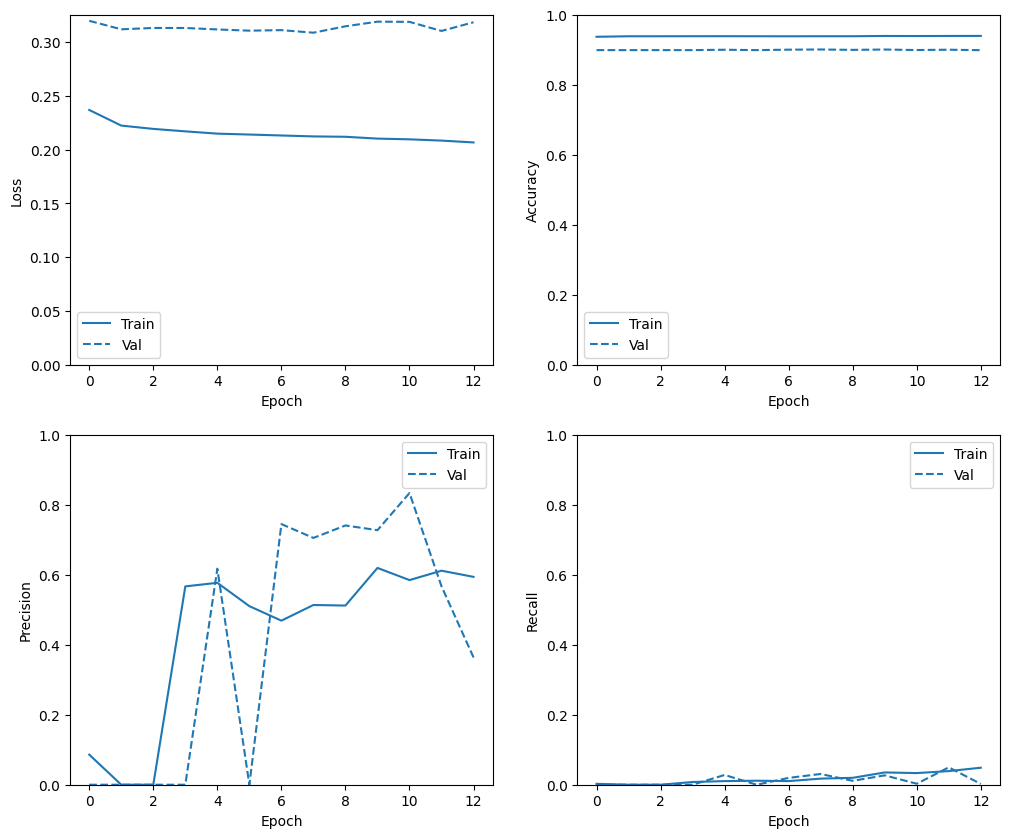

In [828]:
if model_type == 'classifier':
    plot_metrics(history)

In [827]:
model.evaluate(X_test_sequences, y_test_sequences)

1208/1208 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - accuracy: 0.9459 - loss: 0.2084 - precision: 0.1565 - recall: 0.0173


[0.2591322958469391,
 0.9220560789108276,
 0.21069182455539703,
 0.023683279752731323]

In [767]:
tar_pct = round((y_train_sequences.sum() / y_train_sequences.shape)[0],4)
tar_pct

0.0694

In [771]:
round(np.mean(history.history.get('val_precision')),4)

0.4076

In [634]:
file_name = f"{datetime.datetime.now()}_RNN_{model_type}_{quarters_input}_qtr_{threshold}_ths_sc_{small_cap}.pkl"
model_dir = '../models/'
file_name

'2024-09-09 21:28:37.452401_RNN_classifier_8_qtr_0.25_ths_sc_False.pkl'

In [635]:
# Export Pipeline as pickle file
with open(model_dir+file_name, "wb") as file:
    pickle.dump(model, file)

In [637]:
#model = pickle.load(open(model_dir+file_name,"rb"))